# **Multiclass Sentiment Analysis of IMDb Reviews Using Modern NLP Methods**

## **Báo cáo đồ án: Python cho Khoa học dữ liệu**



## **0. Giới thiệu & Mục tiêu dự án**

**Phân tích cảm xúc (Sentiment Analysis)** là một bài toán quan trọng trong Xử lý Ngôn ngữ Tự nhiên **(NLP)**, giúp máy tính hiểu được sắc thái chủ quan **(tích cực/tiêu cực/trung lập)** ẩn sau một đoạn văn bản. Kỹ thuật này giữ vai trò thiết yếu trong nhiều ứng dụng thực tế như khai thác ý kiến người dùng, hệ gợi ý, giám sát mạng xã hội và phân loại nội dung tự động [1][3].

Bộ dữ liệu đánh giá phim **IMDb Movie Reviews** từ lâu đã được sử dụng như một “chuẩn” cho bài toán phân loại cảm xúc. Ở dạng gốc, dataset chỉ gồm **hai nhãn Positive và Negative**, phù hợp chủ yếu cho phân loại **nhị phân** [2]. Tuy nhiên, cảm xúc trong thực tế thường phức tạp và không phải lúc nào cũng rơi vào hai cực rõ ràng. Để khắc phục hạn chế này, dự án này mở rộng bài toán sang phân loại đa lớp với 3 mức cảm xúc:

* **Tiêu cực (0)**  
* **Trung lập (1)**  
* **Tích cực (2)**

Để đảm bảo tính công bằng và ổn định trong quá trình huấn luyện/đánh giá, dự án xây dựng một tập dữ liệu cân bằng gồm **khoảng 75,000 mẫu (mỗi lớp 25,000 mẫu)**. Thiết lập này giúp mô hình diễn giải ý kiến người dùng một cách chi tiết và sát thực tế hơn [1].

Các mục tiêu chính của dự án gồm:

**1. Xây dựng một pipeline NLP hoàn chỉnh**, từ tiền xử lý dữ liệu đến triển khai mô hình.

**2. Huấn luyện mô hình phân loại cảm xúc đa lớp** bằng các kỹ thuật học sâu hiện đại.

**3. So sánh (benchmark) nhiều mô hình Machine Learning và Deep Learning** để đánh giá hiệu năng.

**4. Triển khai một demo Web App gọn nhẹ** nhằm minh họa khả năng dự đoán của mô hình.

Dự án sử dụng **spaCy TextCategorizer (CNN, spaCy 3.x)** làm mô hình chính nhờ tính hiệu quả và thuận tiện khi triển khai [1][3]. Ngoài ra, một số mô hình khác được đưa vào để so sánh:

  * **Logistic Regression**  
  * **Linear Regression (baseline)**  
  * **BiLSTM**  

Quy trình thực hiện dự án gồm các bước:

**1. Chuẩn bị dữ liệu (Data Preparation)**  

**2. Phân tích khám phá dữ liệu (EDA)**  

**3. Tiền xử lý NLP và Vector hóa (Preprocessing & Vectorization)**  

**4. Huấn luyện mô hình (Model Training)**  

**5. Đánh giá mô hình (Model Evaluation)**  

**6. Demo Web Application (Web App Demonstration)**  

## **Thư viện**

In [ ]:
## Standard Library
import numpy as np
import pandas as pd
import os
import re
import random
import html
from typing import Optional

## Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

## TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## SpaCy
import spacy
from spacy.training import Example
from spacy.util import minibatch

## Web Interface - Gradio
import gradio as gr

## **1. Chuẩn bị dữ liệu(Data Preparation)**


### **1.1. Nguồn dữ liệu (Data Sources)**
Để giải quyết bài toán **phân tích cảm xúc đa lớp**, dự án này kết hợp dữ liệu từ hai nguồn chính:

**1. Bộ dữ liệu IMDb:** bộ dữ liệu chuẩn gồm các review phim có nhãn **tích cực/tiêu cực** [2].

**2. Bộ dữ liệu trung lập:** tập bổ sung gồm các review **trung lập**, được **dịch từ tiếng Nga sang tiếng Anh**.


| Dữ liệu | Mô tả | Số mẫu |
|-------|-------|--------|
| **IMDb Dataset** | Đánh giá phim (tiếng Anh) | 50,000 |
| **Neutral Dataset** | Đánh giá trung lập (dịch từ tiếng Nga sang tiếng Anh) | ~25,000 |

**Mục tiêu:** Tạo tập dữ liệu cân bằng ~75,000 mẫu với 3 lớp cảm xúc rõ ràng.

### **1.2. Quy trình xử lý dữ liệu**


#### **1.2.1. Thu thập dữ liệu**

Tải 2 file CSV từ Google Drive:


- pos_neg_data.csv (50,000 mẫu IMDb)

- neutral_data.csv (~25,000 mẫu Neutral)



In [ ]:
# Download IMDb dataset (Negative / Positive)
!gdown 1Uz5AdRH2IPmQSK6dRsnpzU-5Vtz93JhM

# Download Neutral dataset
!gdown 1BHv3SYFqa5TrhBxbd-wddVwRokxHpYRk

Downloading...
From: https://drive.google.com/uc?id=1Uz5AdRH2IPmQSK6dRsnpzU-5Vtz93JhM
To: /content/pos_neg_data.csv
100% 49.9M/49.9M [00:00<00:00, 78.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BHv3SYFqa5TrhBxbd-wddVwRokxHpYRk
To: /content/neutral_data.csv
100% 29.8M/29.8M [00:00<00:00, 82.1MB/s]


In [ ]:
IMDb_data = "/content/pos_neg_data.csv"
print(IMDb_data)

neutral_data = "/content/neutral_data.csv"
print(neutral_data)

/content/pos_neg_data.csv
/content/neutral_data.csv


In [ ]:
df_pn = pd.read_csv(IMDb_data)
df_neu = pd.read_csv(neutral_data)

print("\nIMDb dataset:")
print(df_pn.head(5))
print(f"Columns: {df_pn.columns.tolist()}")
print(f"Shape: {df_pn.shape}")

print("\nNeutral dataset:")
print(df_neu.head(5))
print(f"Columns: {df_neu.columns.tolist()}")
print(f"Shape: {df_neu.shape}")



IMDb dataset:
                                                text  label
0  one other reviewers mentioned after watching j...      2
1  wonderful little production. filming technique...      2
2  i thought wonderful way spend time too hot sum...      2
3  basically there's family where little boy jake...      0
4  petter mattei's love time money visually stunn...      2
Columns: ['text', 'label']
Shape: (50000, 2)

Neutral dataset:
                                                text  label
0  'vivarium', surrealism all consuming emotional...      1
1  film about story man who everything young man ...      1
2  having watched last film completed during dire...      1
3  fact, scream dorm turned out another passable ...      1
4  so, before us creation italian director umbert...      1
Columns: ['text', 'label']
Shape: (24991, 2)


#### **1.2.2. Chuẩn hoá nhãn (Label standardization)**

| Cảm xúc | Giá trị nhãn |
|---------|--------------|
| Negative | 0 |
| Neutral | 1 |
| Positive | 2 |

In [ ]:
df_neu['label'] = 1
print(f"\nAssigned label=1 (Neutral) to {len(df_neu):,} samples")

print("\n- Label Distribution After Standardization:\n")
print("IMDb Dataset:")
print(df_pn['label'].value_counts().sort_index())

print("\nNeutral Dataset:")
print(df_neu['label'].value_counts().sort_index())


Assigned label=1 (Neutral) to 24,991 samples

- Label Distribution After Standardization:

IMDb Dataset:
label
0    25000
2    25000
Name: count, dtype: int64

Neutral Dataset:
label
1    24991
Name: count, dtype: int64


In [ ]:
for label in [0, 2]:
    sample = df_pn[df_pn['label'] == label].iloc[0]
    print(f"\nLabel {label}:")
    print(f"Text: {sample['text'][:]}...")


Label 0:
Text: basically there's family where little boy jake thinks there's zombie his closet his parents fighting all time.this movie slower than soap opera... suddenly, jake decides become rambo kill zombie.ok, first all when you're going make film you decide if thriller drama! drama movie watchable. parents divorcing arguing like real life. then we jake his closet which totally ruins all film! i expected see boogeyman similar movie, instead i watched drama some meaningless thriller spots. out just well playing parents descent dialogs. shots jake just ignore them....

Label 2:
Text: one other reviewers mentioned after watching just oz episode you'll hooked. they right, exactly what happened me.the first thing struck me about oz brutality unflinching scenes violence, which set right word go. trust me, show faint hearted timid. show pulls no punches regards drugs, sex violence. hardcore, classic use word.it called oz nickname given oswald maximum security state penitentary. focuses m

#### **1.2.3. Làm sạch văn bản (Text Cleaning)**
Function `preprocessor()` thực hiện các thao tác sau [1][3]:

- **Loại bỏ thẻ HTML**

- **Loại bỏ URL**

- **Loại bỏ ký tự đặc biệt và số**

- **Chuyển về chữ thường**

- **Chuẩn hóa khoảng trắng**

In [ ]:
def preprocessor(text):
    if not isinstance(text, str):
        return ""
    """
    1. Decode HTML entities (&amp; → &)
    2. Preserve ratings (8/10 → RATING_HIGH)
    3. Remove HTML tags
    4. Remove URLs
    5. Normalize emotion markers (!!!! → !!)
    6. Expand contractions (don't → do not)
    7. Remove remaining numbers
    8. Remove special chars (keep letters, !, ?)
    9. Lowercase
    10. Clean whitespace
    """

    # 1. Decode HTML entities (&amp; → &, &quot; → ")
    text = html.unescape(text)

    # 2. Preserve important ratings (convert to categorical markers)
    text = re.sub(r'\b([89]|10)/10\b', ' RATING_HIGH ', text)  # 8-10/10
    text = re.sub(r'\b[67]/10\b', ' RATING_MID ', text)         # 6-7/10
    text = re.sub(r'\b[1-5]/10\b', ' RATING_LOW ', text)        # 1-5/10

    # 3. Remove HTML tags
    text = re.sub(r'<[^>]*>', ' ', text)

    # 4. Remove URLs
    text = re.sub(r'http\S+|www\.\S+', ' ', text)

    # 5. Normalize emotion intensity (!!! → !!, ??? → ??)
    text = re.sub(r'([!?]){3,}', r'\1\1', text)

    # 6. Expand common contractions
    contractions = {
        r"\bdon't\b": "do not",
        r"\bwon't\b": "will not",
        r"\bcan't\b": "cannot",
        r"\bI'm\b": "I am",
        r"\bit's\b": "it is",
        r"\bhe's\b": "he is",
        r"\bshe's\b": "she is",
        r"\bthat's\b": "that is",
        r"\bwhat's\b": "what is",
        r"\bwhere's\b": "where is",
        r"\bhow's\b": "how is",
        r"\bI've\b": "I have",
        r"\bwe've\b": "we have",
        r"\bthey've\b": "they have",
        r"\bI'd\b": "I would",
        r"\byou'd\b": "you would",
        r"\bhe'd\b": "he would",
        r"\bI'll\b": "I will",
        r"\byou'll\b": "you will",
        r"\bisn't\b": "is not",
        r"\baren't\b": "are not",
        r"\bwasn't\b": "was not",
        r"\bweren't\b": "were not",
        r"\bhasn't\b": "has not",
        r"\bhaven't\b": "have not",
        r"\bhadn't\b": "had not",
        r"\bdoesn't\b": "does not",
        r"\bdidn't\b": "did not",
        r"\bcouldn't\b": "could not",
        r"\bshouldn't\b": "should not",
        r"\bwouldn't\b": "would not",
    }

    for pattern, replacement in contractions.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    # 7. Remove remaining numbers (after converting ratings)
    text = re.sub(r'\b\d+\b', ' ', text)

    # 8. Remove special characters (keep letters, spaces, !, ?)
    text = re.sub(r'[^a-zA-Z\s!?]', ' ', text)

    # 9. Lowercase
    text = text.lower()

    # 10. Clean whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
df_pn['text'] = df_pn['text'].apply(preprocessor)
df_neu['text'] = df_neu['text'].apply(preprocessor)

# Show examples
print("\nSample cleaned text:")
print(f"{df_pn.iloc[0]['text'][:200]}...")


Sample cleaned text:
one other reviewers mentioned after watching just oz episode you will hooked they right exactly what happened me the first thing struck me about oz brutality unflinching scenes violence which set righ...


#### **1.2.4. Gộp dữ liệu (Merging dataframes)**
Kết hợp 2 nguồn dữ liệu (IMDb + Neutral) thành một DataFrame duy nhất [1][2].

- **Chọn cột cần thiết:** Chỉ giữ `text` và `label`

- **Gộp DataFrame**

- **Xáo trộn (Shuffle)**

- **Lọc dữ liệu**

In [ ]:
# Merge
df_final = pd.concat([
    df_pn[['text', 'label']],
    df_neu[['text', 'label']]
], ignore_index=True)

# Filter empty and short texts
print(f"\nBefore filtering: {len(df_final):,} samples")

df_final = df_final[df_final['text'].str.strip() != '']
print(f"After removing empty texts: {len(df_final):,} samples")

df_final = df_final[df_final['text'].str.split().str.len() > 5]
print(f"After removing short texts (<5 words): {len(df_final):,} samples")

# Show distribution
print("\nFinal Label Distribution:")
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

for label, count in df_final['label'].value_counts().sort_index().items():
    pct = count/len(df_final)*100
    print(f"  {label_map[label]}: {count:,} ({pct:.1f}%)")


Before filtering: 74,991 samples
After removing empty texts: 74,467 samples
After removing short texts (<5 words): 72,518 samples

Final Label Distribution:
  Negative: 24,997 (34.5%)
  Neutral: 22,521 (31.1%)
  Positive: 25,000 (34.5%)


#### **1.2.5. Chia tập dữ liệu (DATA SPLITTING)**

| Tập | Tỉ lệ | Mục đích |
|-----|-------|----------|
| Training | 70% | Huấn luyện |
| Validation | 15% | Điều chỉnh siêu tham số |
| Test | 15% | Đánh giá cuối cùng |

**Phương pháp:** Sử dụng stratified split để đảm bảo phân bố nhãn cân bằng trên cả 3 tập.

In [ ]:
"""
- 70% Training
- 15% Validation
- 15% Test
"""

# Extract features and labels
X = df_final['text'].values
y = df_final['label'].values

# Step 1: Split into Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

print("\nStep 1: Train/Temp Split")
print(f"Training: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Temp: {len(X_temp):,} samples ({len(X_temp)/len(X)*100:.1f}%)")

# Step 2: Split Temp into Validation (50%) and Test (50%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("\nStep 2: Validation/Test Split from Temp")
print(f"Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")



Step 1: Train/Temp Split
Training: 50,762 samples (70.0%)
Temp: 21,756 samples (30.0%)

Step 2: Validation/Test Split from Temp
Validation: 10,878 samples (15.0%)
Test: 10,878 samples (15.0%)


In [ ]:
# Create DataFrames
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

# Summary
print(f"\nTotal samples: {len(df_final):,}\n")
print(f"{'Dataset':<15} {'Samples':>10} {'Ratio':>10}")
print("-" * 40)
print(f"{'Training':<15} {len(train_df):>10,} {len(train_df)/len(df_final)*100:>9.1f}%")
print(f"{'Validation':<15} {len(val_df):>10,} {len(val_df)/len(df_final)*100:>9.1f}%")
print(f"{'Test':<15} {len(test_df):>10,} {len(test_df)/len(df_final)*100:>9.1f}%")



Total samples: 72,518

Dataset            Samples      Ratio
----------------------------------------
Training            50,762      70.0%
Validation          10,878      15.0%
Test                10,878      15.0%


#### **1.2.6. Lưu và hiển thị mẫu**

Lưu 3 tập dữ liệu thành file CSV: `train_data.csv`, `val_data.csv`, `test_data.csv` để sử dụng trong các bước tiếp theo (EDA, Training).

| File | Nội dung | Số mẫu |
|------|----------|--------|
| `train_data.csv` | Tập huấn luyện | ~50,762 |
| `val_data.csv` | Tập validation | ~10,878 |
| `test_data.csv` | Tập test | ~10,878 |

In [ ]:
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

print("10 training samples")
print(train_df.head(10))

label_names = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}

print("Sample from each label")
for label in [0, 1, 2]:
    sample = train_df[train_df['label'] == label].iloc[0]
    print(f"\nLabel {label} ({label_names[label]}):")
    print(f"Text: {sample['text'][:150]}...")
    print(f"Length: {len(sample['text'].split())} words")

10 training samples
                                                text  label
0  ah yes it is yet another retelling classic soc...      0
1  bizarre experiment astronaut abandoned moon al...      2
2  film about group extra terrestrial gay black m...      0
3  i think i have seen all grisham movies now gen...      0
4  after his widower father dies horsing accident...      0
5  i really liked movie totally reminds me my hig...      2
6  rules engagement one best documentaries i ever...      2
7  name eagle quite embarrassing what you do? all...      1
8  improvisation used groundbreaking degree film ...      2
9  i decided watch because recommendations site i...      2
Sample from each label

Label 0 (Negative):
Text: ah yes it is yet another retelling classic sociopathic murderous doctor creates female frankenstein falls love from same director who brought you such...
Length: 123 words

Label 1 (Neutral):
Text: name eagle quite embarrassing what you do? all remains dubrovsky names q

## **2. Khai phá dữ liệu (EDA)**


### **2.1 Class distribution**
Đầu tiên sẽ kiểm tra tần suất của từng nhãn cảm xúc và trực quan hóa kết quả bằng biểu đồ cột để cung cấp sự so sánh rõ ràng về phân bố lớp. Tiếp theo, dữ liệu được biểu diễn bằng biểu đồ tròn để minh họa tỷ lệ phần trăm của từng lớp trong toàn bộ tập dữ liệu. Phân tích này giúp đánh giá sự cân bằng của tập dữ liệu và xác định các vấn đề mất cân bằng lớp có thể ảnh hưởng đến quá trình huấn luyện mô hình [1][3].

In [ ]:
df = df_final
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72518 entries, 0 to 74990
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    72518 non-null  object
 1   label   72518 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
print(df['label'].value_counts())

label
2    25000
0    24997
1    22521
Name: count, dtype: int64


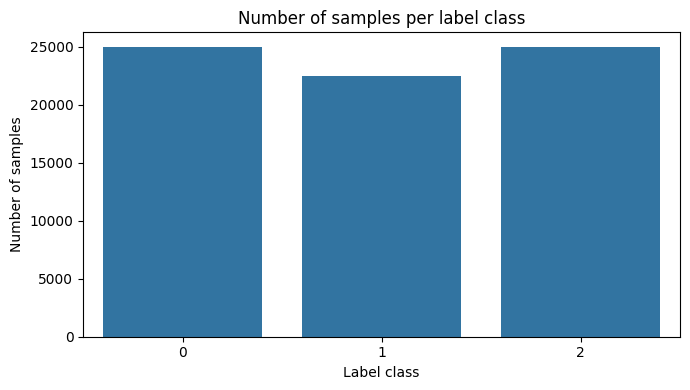

In [ ]:
class_counts = df["label"].value_counts()

plt.figure(figsize=(7,4))
sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title("Number of samples per label class")
plt.ylabel("Number of samples")
plt.xlabel("Label class")
plt.tight_layout()
plt.show()

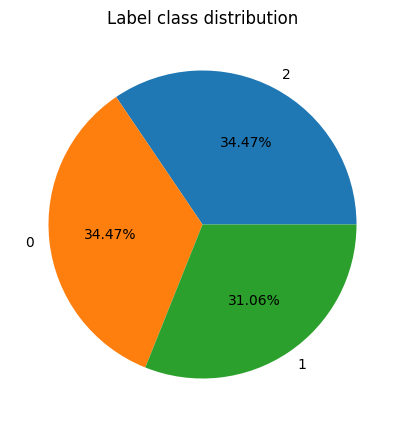

In [ ]:
plt.figure(figsize=(5,5))
class_counts.plot(kind='pie', autopct="%1.2f%%")
plt.title("Label class distribution")
plt.ylabel("")
plt.show()

### **2.2 Phân bố độ dài văn bản**

In [ ]:
before = len(df)
df_clean = df.drop_duplicates(subset=["text"])
after = len(df_clean)

print("Number of samples before removing duplicates:", before)
print("Number of samples after removing duplicates:", after)
print("Number of duplicated samples:", before - after)

Number of samples before removing duplicates: 72518
Number of samples after removing duplicates: 71732
Number of duplicated samples: 786


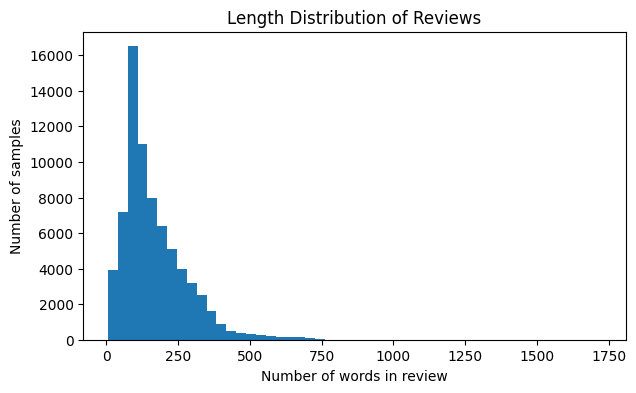

In [ ]:
df["length"] = df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(7,4))
plt.hist(df["length"], bins=50)
plt.title("Length Distribution of Reviews")
plt.xlabel("Number of words in review")
plt.ylabel("Number of samples")
plt.show()

### **2.3 WordCloud**
WordCloud được sử dụng như một công cụ trực quan để giúp mô tả các đặc điểm ngôn ngữ của một bộ dữ liệu. Bằng cách thể hiện tần suất xuất hiện của các từ thông qua kích thước và vị trí trong đám mây từ, các nhà phân tích có thể nhanh chóng xác định các từ khóa nổi bật, các chủ đề phổ biến hoặc các mẫu ngôn ngữ đặc trưng trong toàn bộ văn bản [1][3].

#### (I) Word Cloud of 'Positive' Sentiment

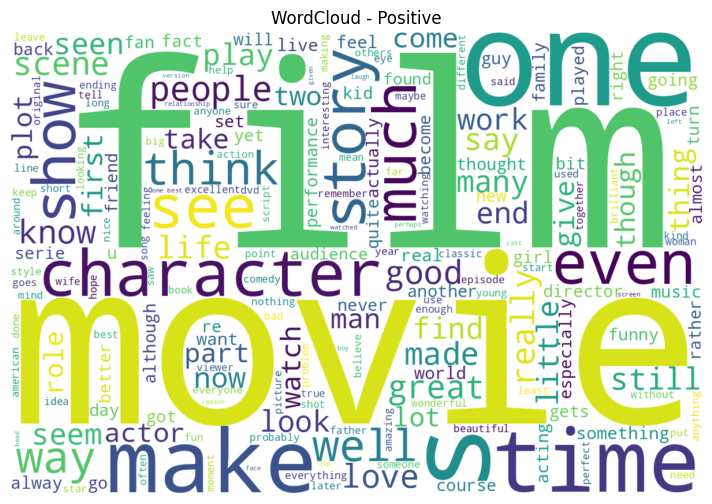

In [ ]:
positive_texts = df_clean[df_clean.label == 2]["text"] ## 2 = Positive

all_text_pos = " ".join(positive_texts)

wc_pos = WordCloud(width=1200, height=800, background_color="white").generate(all_text_pos)

plt.figure(figsize=(10,6))
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Positive")
plt.show()

#### (II) Word Cloud of 'Neutral' Sentiment

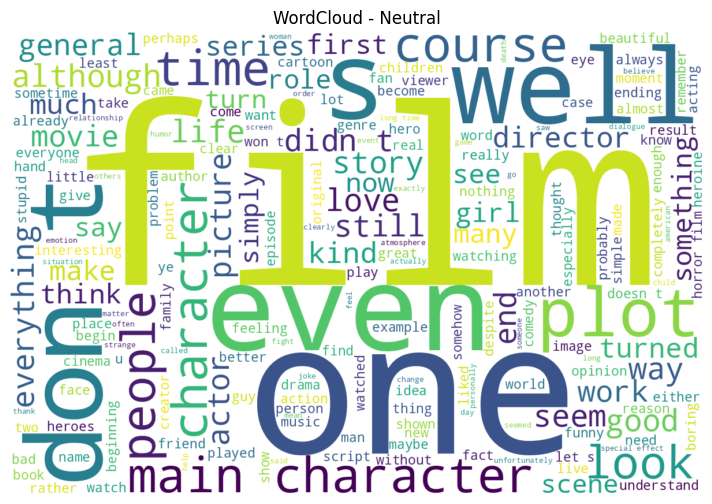

In [ ]:
neutral_texts = df_clean[df_clean.label == 1]["text"]

all_text_neu = " ".join(neutral_texts)

wc_neu = WordCloud(width=1200, height=800, background_color="white").generate(all_text_neu)

plt.figure(figsize=(10,6))
plt.imshow(wc_neu, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Neutral")
plt.show()

#### (III) Word Cloud of 'Negative' Sentiment

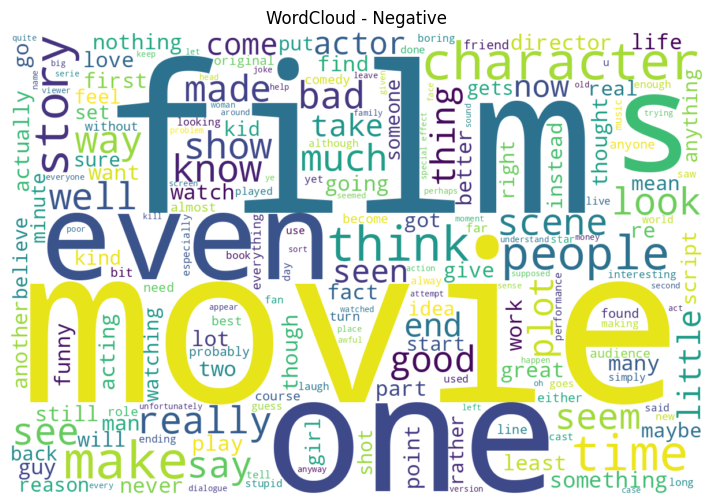

In [ ]:
negative_texts = df_clean[df_clean.label == 0]["text"]

all_text_neg = " ".join(negative_texts)

wc_neg = WordCloud(width=1200, height=800, background_color="white").generate(all_text_neg)

plt.figure(figsize=(10,6))
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Negative")
plt.show()

Nhìn chung, quá trình EDA cung cấp những hiểu biết cần thiết về đặc điểm và chất lượng của bộ dữ liệu. Việc phân tích phân phối lớp, độ dài văn bản, các đặc trưng từ vựng và các bản ghi trùng lặp giúp đánh giá sự cân bằng, tính đa dạng và các bất thường tiềm ẩn của dữ liệu. Những phát hiện này cung cấp nền tảng quan trọng để lựa chọn các chiến lược tiền xử lý phù hợp và góp phần nâng cao hiệu suất của các mô hình học máy trong các giai đoạn tiếp theo [1][3].

## **3. NLP Preprocessing & Text Vectorization**

Đề tài này sử dụng các model khác nhau: SpacyCNN, Logistic Regression, BiLSTM. Tuy nhiên chỉ có 2 model cần dữ liệu đầu vào ở dạng chuẩn hóa là Logistic Regression với kiểu chuẩn hóa TF-IDF và BiLSTM với kiểu chuẩn hóa Glove [1][2][3]. Dưới đây sẽ là quy trình chuẩn hóa mẫu của một đoạn đánh giá.

Câu được chọn để minh họa, được lấy từ tập test và đã được loại bỏ HTML tag

In [ ]:
implement=test_df.loc[6]["text"]
implement

'movie worst horror movie i ever seen acting terrible horrible cheesy talk about predictable plot i never watch movie again nor i recommend movie anyone what waste time first soon movie began i realized what i got myself into all they movie copy scenes many other horror movies out there bunched them all into one movie prank phone calls halloween night psycho one knife absolutely ridiculous i scared all during movie which i thought horror movies supposed do making movie pretty hilarious how they all talk about how movie so great so scary i mean how you realize movies cheap rip off scary movie example least get some good actors there then maybe pulled off good horror movie'

Quá trình preprocessing gồm 4 bước [1][3]:

1. **Tokenizing:** Tách đoạn thành các token  
2. **Remove Stopwords:** Xóa các stopword như he, she, I, me,...  
3. **Normalize word:** Đưa các hình thức khác nhau của từ về 1 dạng duy nhất  
4. **Vectorize text:** Thực hiện phép biến đổi đoạn thành 1 vector duy nhất

### **3.1 + 3.2 Tokenizing + Remove Stopwords, emoji, number(Sử dụng thư viện spacy)**

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"]) # An English language processing model

def spacy_preprocess_one(text):
    doc = nlp(str(text)) # Split the input sentence into tokens and assign attributes to each token
    tokens = [
        token.text.lower()
        for token in doc # Loop through each token obtained from the tokenization step.
          if not token.is_stop and not token.is_punct and token.is_alpha # Keep only tokens that are alphabetic, not stopwords, and not special characters.
    ]
    return " ".join(tokens)

In [ ]:
processed_sentiment = spacy_preprocess_one(implement)
print(processed_sentiment)

movie worst horror movie seen acting terrible horrible cheesy talk predictable plot watch movie recommend movie waste time soon movie began realized got movie copy scenes horror movies bunched movie prank phone calls halloween night psycho knife absolutely ridiculous scared movie thought horror movies supposed making movie pretty hilarious talk movie great scary mean realize movies cheap rip scary movie example good actors maybe pulled good horror movie


### **3.3 Normalize words**

Sử dụng phương pháp chuẩn hóa lemma (spacy hỗ trợ)

In [ ]:
def spacy_preprocess_lemma_one(text):
    if pd.isna(text) or text is None:
        return ""

    doc = nlp(str(text))

    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and token.is_alpha
    ]

    return " ".join(tokens)

In [ ]:
processed_sentiment2 = spacy_preprocess_lemma_one(processed_sentiment)
print(processed_sentiment2)

movie bad horror movie see act terrible horrible cheesy talk predictable plot watch movie recommend movie waste time soon movie begin realize get movie copy scene horror movie bunch movie prank phone call halloween night psycho knife absolutely ridiculous scared movie think horror movie suppose make movie pretty hilarious talk movie great scary mean realize movie cheap rip scary movie example good actor maybe pull good horror movie


## **4. Model Training**
### **4.1 spaCy TextCategorizer (CNN - Main Model)**
#### **4.1.1. Kiến trúc CNN trong spaCy TextCategorizer**
**The TextCategorizer** trong spaCy được sử dụng để thực hiện bài toán phân loại văn bản [1][3].

Trong nghiên cứu này, chúng em dùng thiết lập **đa lớp một nhãn (single-label multi-class)**, nghĩa là mỗi văn bản chỉ được gán đúng một nhãn cảm xúc trong ba nhóm: **Tiêu cực, Trung lập và Tích cực**.
Sự phân loại sẽ đi theo các kiến trúc **tok2vec → CNN → Softmax** [1][3]:

1. Văn bản đầu vào trước hết được tách thành các token, sau đó mỗi token được mã hoá thành một vector đặc (dense vector) bởi thành phần **tok2vec**.

2. Chuỗi vector token thu được sau đó được đưa vào một chồng các lớp mạng nơ ron tích chập **convolutional neural network (CNN)**, nhằm trích xuất đặc trưng ngữ cảnh cục bộ từ văn bản.  
Đầu ra của CNN được pooling để tạo thành một biểu diễn có độ dài cố định $h(x)$, sau đó được đưa vào lớp phân loại cuối cùng nhằm sinh ra phân phối xác suất trên các lớp cảm xúc:
$$
P(y|x) = \text{softmax}(W \cdot h(x) + b)
$$

Với:
* $h(x)$ là vector đặc trưng được trích xuất,
* $W, b$ là các tham số học được của bộ phân loại (classifier).

Mô hình được huấn luyện bằng cách tối thiểu hoá hàm mất mát **cross-entropy đa lớp** [1][3]:
$$
\mathcal{L} = - \sum_{c=1}^{3} y_c \log(\hat{y}_c)
$$

* $\hat{y}(x)$ là vector xác suất dự đoán:
  * $\hat{y}_{neg}(x)$ xác suất của nhãn tiêu cực
  * $\hat{y}_{neu}(x)$ xác suất của nhãn trung lập
  * $\hat{y}_{pos}(x)$ xác suất của nhãn tích cực

* **Mục tiêu huấn luyện:** Học bộ tham số $\theta = \{W, b\}$ sao cho hàm mất mát $\mathcal{L}$ đạt giá trị nhỏ nhất.

#### **4.1.2. Siêu tham số (Hyperparameters)**

Trong thực tế, cần tinh chỉnh một số siêu tham số để đạt hiệu năng tối ưu, gồm **learning rate, batch size, số epoch huấn luyện và dropout rate**. Các siêu tham số này ban đầu được chọn theo các thiết lập thực nghiệm phổ biến, sau đó tiếp tục điều chỉnh dựa trên kết quả theo dõi trên tập validation [1][3].

#### **4.1.3.Chỉnh sửa spaCy Pipeline để thêm textcat_multiclass**
Bước đầu tiên là khởi tạo một pipeline spaCy rỗng, sau đó thêm thành phần `textcat_multiclass`. Thành phần này chịu trách nhiệm phân loại cảm xúc cho văn bản đầu vào [1][3].

Thêm các nhãn:
  * `"neg"`
  * `"neu"`
  * `"pos"`

In [ ]:
print(spacy.__version__)

3.8.11


In [ ]:
# Make empty spaCy pipeline
nlp = spacy.blank("en")

# Define LABEL_MAP here so it's available
LABEL_MAP = {0: "neg", 1: "neu", 2: "pos"}

# Add a text classification (textcat) component to the pipeline with the default config
textcat = nlp.add_pipe("textcat")

# Add 3 sentiments label
for label in LABEL_MAP.values():
    textcat.add_label(label)

# Initialize model parameters
nlp.initialize()

print(nlp.pipe_names)

['textcat']


#### **4.1.4. Chuẩn bị dữ liệu để Huấn luyện**
spaCy yêu cầu dữ liệu training có dạng [1][3]:

`(text, {"cats": {"neg": 0/1, "neu": 0/1, "pos": 0/1}})`

**Example:**

``("The movie was amazing.", {"cats": {"neg": 0, "neu": 0, "pos": 1}})``

``("It was okay, nothing special.", {"cats": {"neg": 0, "neu": 1, "pos": 0}})``

**Chuyển đổi từ DataFrame sang dạng spaCy**

In [ ]:
def df_to_spacy_format(df):
    formatted = []
    for text, label in zip(df["text"], df["label"]):
        label = int(label)
        cats = {lbl: 0.0 for lbl in LABEL_MAP.values()}
        cats[LABEL_MAP[label]] = 1.0
        formatted.append((str(text), {"cats": cats}))
    return formatted


train_data = df_to_spacy_format(train_df)
val_data   = df_to_spacy_format(val_df)
test_data  = df_to_spacy_format(test_df)

print("Example training sample:")
print(train_data[0])

Example training sample:
('ah yes it is yet another retelling classic sociopathic murderous doctor creates female frankenstein falls love from same director who brought you such timeless classics maniacs no group blood feast unfinished film virtually cries out mst k treatment doctor s assistant even overtones torgo classic manos hands fate i do not know if graphic if fake looking violence frequent stretches dialogue free tedium scared crew off though the main reasons bother sitting through movie hysterical hypnosis scene laughably serious ending rock bottom production values i actually watched all credits after movie same reasons you re inclined slow down your car when you pass serious traffic accident sheer genius end theme sounds like watered down my favorite things played toy piano goblin ain t', {'cats': {'neg': 1.0, 'neu': 0.0, 'pos': 0.0}})


#### **4.1.5. Xây dựng Training Loop**
Dựa trên pipeline và data đã chuẩn bị, bây giờ sẽ xây dựng một Training loop [1][3].

Với mỗi epoch, vòng lặp:
  1. Trộn các dữ liệu training lại với nhau
  2. Chia chúng thành các nhóm nhỏ
  3. Chuyển từng nhóm này thành các danh sách đối tượng `Example`
  4. Gọi `nlp.update()` để thực hiện lan truyền tiến, ngược và cập nhật lại hệ số
  5. Ghi lại theo dõi các training loss -> kiểm tra việc hội tụ

In [ ]:
# Siêu tham số - Hyperparameters
n_epochs = 20
batch_size = 32
dropout = 0.2

def evaluate_model(nlp, data):
    correct = 0
    total = 0
    for text, ann in data:
        doc = nlp(text)
        pred = max(doc.cats, key=doc.cats.get)            # predicted label
        true = max(ann["cats"], key=ann["cats"].get)      # true label
        if pred == true:
            correct += 1
        total += 1
    return correct / total if total > 0 else 0.0

best_val_acc = 0.0
best_model_path = "spacy_textcat_multiclass"

In [ ]:
for epoch in range(1, n_epochs + 1):
    random.shuffle(train_data)
    batches = minibatch(train_data, size=batch_size)
    losses = {}

    for batch in batches:
        texts, annotations = zip(*batch)
        examples = [
            Example.from_dict(nlp.make_doc(text), ann)
            for text, ann in zip(texts, annotations)
        ]
        nlp.update(examples, drop=dropout, losses=losses)

    train_loss = losses.get("textcat", 0.0)
    val_acc = evaluate_model(nlp, val_data)

    print(
        f"Epoch {epoch}/{n_epochs} - "
        f"Train Loss: {train_loss:.4f} - Val Acc: {val_acc:.4f}"
    )

    # Saving best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        nlp.to_disk(best_model_path)
        print(f"-> Best model saved with Val Acc = {best_val_acc:.4f}")

#### **4.1.6. Đánh giá mô hình trong quá trình huấn luyện**
Vì spaCy không tự động đánh giá mô hình trong lúc training, nên ta cài đặt một hàm đánh giá riêng `(evaluate_model)` như ở trên [1][3]. Hàm này:
  * Chạy pipeline `nlp` hiện tại trên từng mẫu trong tập valid hoặc test
  * So sánh nhãn dự đoán (argmax của `doc.cats`) với nhãn thật (argmax của `"cats"`)
  * Tính độ chính xác (accuracy)

Gọi hàm này ở cuối mỗi epoch giúp:
  * Theo dõi khả năng khái quát hóa của mô hình
  * Chọn checkpoint có validation accuracy cao nhất

In [ ]:
def evaluate_model(nlp, data):
    y_true = []
    y_pred = []

    for text, ann in data:
        doc = nlp(text)
        pred = max(doc.cats, key=doc.cats.get)           # predicted label
        true = max(ann["cats"], key=ann["cats"].get)     # auth label
        y_true.append(true)
        y_pred.append(pred)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Precision, Recall, F1 (macro)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)

    # F1 weighted
    _, _, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

    print(classification_report(y_true, y_pred, digits=4))

    return acc, prec_macro, rec_macro, f1_macro, f1_weighted

#### **4.1.7. Lưu và tải lại Final Model**
Mô hình tốt nhất trong quá trình huấn luyện được lưu bằng `nlp.to_disk()`. Pipeline đã lưu có thể được tải lại để suy luận (inference) và triển khai trong Web Application.

In [ ]:
%%time
best_nlp = spacy.load(best_model_path)

test_acc, test_prec, test_rec, test_f1_macro, test_f1_weighted = evaluate_model(best_nlp, test_data)

print(f"Test Accuracy : {test_acc:.4f}")
print(f"Test Precision : {test_prec:.4f}")
print(f"Test Recall : {test_rec:.4f}")
print(f"Test F1 (macro) : {test_f1_macro:.4f}")
print(f"Test F1 (weighted) : {test_f1_weighted:.4f}")

## **5.Các mô hình khác**
Trong phần này, sẽ trình bày các mô hình được triển khai để phân loại cảm xúc trong bộ dữ liệu đánh giá phim với ba nhãn: Tiêu cực, Trung lập và Tích cực. Mỗi mô hình sử dụng một phương pháp biểu diễn văn bản và kiến trúc khác nhau, nhằm so sánh hiệu quả của các kỹ thuật truyền thống và các mô hình spaCy [1][2][3].

### **5.1 Logistic Regression with TF-IDF**
Trong mô hình này, các văn bản đánh giá phim được xử lý bằng phương pháp TF-IDF (Tần số Thuật ngữ – Tần số Ngược của Tài liệu) để biến mỗi câu đánh giá thành một vector đặc trưng phản ánh tầm quan trọng của từng từ trong toàn bộ tập dữ liệu [1][3]. Để nắm bắt tốt hơn các cụm từ đặc trưng trong bối cảnh đánh giá phim, TF-IDF được huấn luyện với `ngram_range = (1, 2)`, có nghĩa là mô hình sử dụng cả các từ đơn (unigram) và các cụm từ hai từ (bigram).

#### **5.1.1 Logistic Regression**
Các vector này được đưa vào mô hình Hồi quy Logistic, một bộ phân loại tuyến tính sử dụng hàm Softmax để dự đoán xác suất cho ba lớp cảm xúc [1][3]. Mô hình được huấn luyện với `max_iter = 2000` để đảm bảo hội tụ khi xử lý không gian vector có số chiều cao.

In [ ]:
for df in [train_df, val_df, test_df]:
    df['text'] = df['text'].astype(str).fillna("")
# Vector
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_val_tfidf   = tfidf.transform(val_df['text'])
X_test_tfidf  = tfidf.transform(test_df['text'])

In [ ]:
%%time
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_tfidf, train_df['label'])

y_pred_lr = lr.predict(X_test_tfidf)
print(classification_report(test_df['label'], y_pred_lr, digits=4))

              precision    recall  f1-score   support

           0     0.9046    0.8949    0.8997      3750
           1     0.9879    0.9754    0.9816      3257
           2     0.8880    0.9072    0.8975      3750

    accuracy                         0.9236     10757
   macro avg     0.9268    0.9259    0.9263     10757
weighted avg     0.9240    0.9236    0.9237     10757

CPU times: user 15 s, sys: 22.3 ms, total: 15 s
Wall time: 8.82 s


### **5.2 Linear Regression**
Mô hình Linear Regression được sử dụng như một chuẩn cơ bản đơn giản để so sánh với các phương pháp phân loại khác [1][3]. Trong mô hình này, bài toán phân loại cảm xúc được chuyển thành bài toán hồi quy, nơi các nhãn cảm xúc được mã hóa thành giá trị số:

* Negative thành 0  
* Neutral thành 1  
* Positive thành 2  

Linear Regression học một hàm ánh xạ tuyến tính:
$$
y = Wx + b
$$

Mặc dù không được thiết kế cho phân loại rời rạc, mô hình này giúp đánh giá khả năng tách tuyến tính của dữ liệu TF-IDF trong nhiệm vụ phân tích cảm xúc [1][3].

Sau khi mô hình dự đoán giá trị liên tục, đầu ra sẽ được làm tròn và giới hạn trong khoảng 0 - 2 để thu được nhãn phân loại hợp lệ.


In [ ]:
lr_base = LinearRegression()
lr_base.fit(X_train_tfidf, train_df['label'])

y_pred_lr_base = lr_base.predict(X_test_tfidf)
y_pred_lr_base = np.clip(np.round(y_pred_lr_base), 0, 2).astype(int)

print(classification_report(test_df['label'], y_pred_lr_base, digits=4))

              precision    recall  f1-score   support

           0     0.7963    0.5899    0.6777      3750
           1     0.4483    0.7037    0.5477      3257
           2     0.7683    0.5872    0.6657      3750

    accuracy                         0.6234     10757
   macro avg     0.6709    0.6269    0.6303     10757
weighted avg     0.6812    0.6234    0.6341     10757



Mặc dù Hồi quy tuyến tính không đạt hiệu suất cao trong phân loại cảm xúc, nó vẫn đóng vai trò là một chuẩn mực quan trọng để so sánh với các mô hình phân loại truyền thống và học sâu.

### **5.3 BiLSTM**
The BiLSTM (Bidirectional Long Short-Term Memory) mô hình được sử dụng để nắm bắt ngữ cảnh hai chiều trong các câu đánh giá phim. Khác với các mô hình TF-IDF tuyến tính, BiLSTM hoạt động trực tiếp trên các chuỗi từ đã được tách token và chuyển chúng thành các vectơ nhúng được học trong quá trình huấn luyện [1][3].

**Dữ liệu đầu vào**

Văn bản được xử lý thông qua:

* Bộ tách token với tối đa 20.000 từ phổ biến nhất
* Làm đầy các chuỗi đến độ dài cố định `MAX_LEN = 200`
* Mã hóa one-hot các nhãn thành các vectơ 3 chiều tương ứng với 3 lớp cảm xúc

**Kiến trúc BiLSTM**

1. **Lớp Nhúng (Embedding Layer)**  
   Chuyển từng token thành vectơ 128 chiều.

2. **LSTM Hai Chiều (128 đơn vị)**  
   Xử lý các chuỗi theo cả hai hướng trái sang phải và phải sang trái, tạo ra các biểu diễn ngữ cảnh phong phú hơn:
   $$
   h_t = [\overrightarrow{h_t}; \overleftarrow{h_t}]
   $$

3. **Dropout 0.3**  
   Giảm overfitting.

4. **Dense + Softmax**  
   Dự đoán phân phối xác suất cho 3 lớp cảm xúc.

#### **5.3.1 BiLSTM**

In [ ]:
MAX_WORDS = 20000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['text'])

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_df['text']), maxlen=MAX_LEN)
X_val_seq   = pad_sequences(tokenizer.texts_to_sequences(val_df['text']), maxlen=MAX_LEN)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(test_df['text']), maxlen=MAX_LEN)

y_train_nn = tf.keras.utils.to_categorical(train_df['label'], 3)
y_val_nn   = tf.keras.utils.to_categorical(val_df['label'], 3)
y_test_nn  = tf.keras.utils.to_categorical(test_df['label'], 3)

inputs = layers.Input(shape=(MAX_LEN,))
x = layers.Embedding(MAX_WORDS, 128)(inputs)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(3, activation="softmax")(x)

bilstm_model = Model(inputs, outputs)
bilstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
bilstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,823,939 (10.77 MB)

 Trainable params: 2,823,939 (10.77 MB)

 Non-trainable params: 0 (0.00 B)

#### **5.3.2 Train BiLSTM**

In [ ]:
%%time
history = bilstm_model.fit(
    X_train_seq, y_train_nn,
    validation_data=(X_val_seq, y_val_nn),
    epochs=3,
    batch_size=64
)

Epoch 1/3
785/785 ━━━━━━━━━━━━━━━━━━━━ 25s 25ms/step - accuracy: 0.7100 - loss: 0.5822 - val_accuracy: 0.8987 - val_loss: 0.2634
Epoch 2/3
785/785 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9175 - loss: 0.2279 - val_accuracy: 0.9015 - val_loss: 0.2528
Epoch 3/3
785/785 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.9466 - loss: 0.1474 - val_accuracy: 0.8918 - val_loss: 0.2963
CPU times: user 53.9 s, sys: 2.46 s, total: 56.4 s
Wall time: 1min 4s


In [ ]:
%%time
y_pred_bilstm = bilstm_model.predict(X_test_seq).argmax(axis=1)
print(classification_report(test_df['label'], y_pred_bilstm, digits=4))

337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
              precision    recall  f1-score   support

           0     0.8245    0.8960    0.8588      3750
           1     0.9929    0.9447    0.9682      3257
           2     0.8660    0.8275    0.8463      3750

    accuracy                         0.8869     10757
   macro avg     0.8945    0.8894    0.8911     10757
weighted avg     0.8900    0.8869    0.8876     10757

CPU times: user 2.82 s, sys: 95.7 ms, total: 2.92 s
Wall time: 2.66 s


## **6. Web App Demonstration (Streamlit)**

In [ ]:
# Load trained spaCy pipeline
best_model_path = "spacy_textcat_multiclass"
nlp = spacy.load(best_model_path)

def remove_html_tags(text):
    return re.sub(r"<.*?>", "", text)

def predict_pipeline(text):
    cleaned_text = remove_html_tags(text)

    doc = nlp(cleaned_text)
    cats = doc.cats  # dict: {"neg": prob, "neu": prob, "pos": prob}

    pred = max(cats, key=cats.get)
    # Format the output to display probabilities for better readability.
    score_str = " | ".join([f"{k}:{v:.4f}" for k, v in sorted(cats.items())])

    return cleaned_text, f"{pred}  ({score_str})"

with gr.Blocks() as demo:
    gr.Markdown(
        """
        <div style="text-align:center">
            <img src="https://upload.wikimedia.org/wikipedia/vi/c/ca/Tr%C6%B0%E1%BB%9Dng_%C4%90%E1%BA%A1i_h%E1%BB%8Dc_Khoa_h%E1%BB%8Dc_T%E1%BB%B1_nhi%C3%AAn%2C_%C4%90%E1%BA%A1i_h%E1%BB%8Dc_Qu%E1%BB%91c_gia_Th%C3%A0nh_ph%E1%BB%91_H%E1%BB%93_Ch%C3%AD_Minh.svg" width="150">
            <h1>Predict the Sentiment from Evaluation</h1>
            <p>spaCy TextCategorizer inference demo</p>
        </div>
        """
    )

    inp = gr.Textbox(label="Evaluation", lines=4)
    cleaned = gr.Textbox(label="After removing HTML tags", lines=4)
    out = gr.Textbox(label="Sentiment (with probs)")

    btn = gr.Button("Prediction")
    btn.click(fn=predict_pipeline, inputs=inp, outputs=[cleaned, out])

demo.launch()

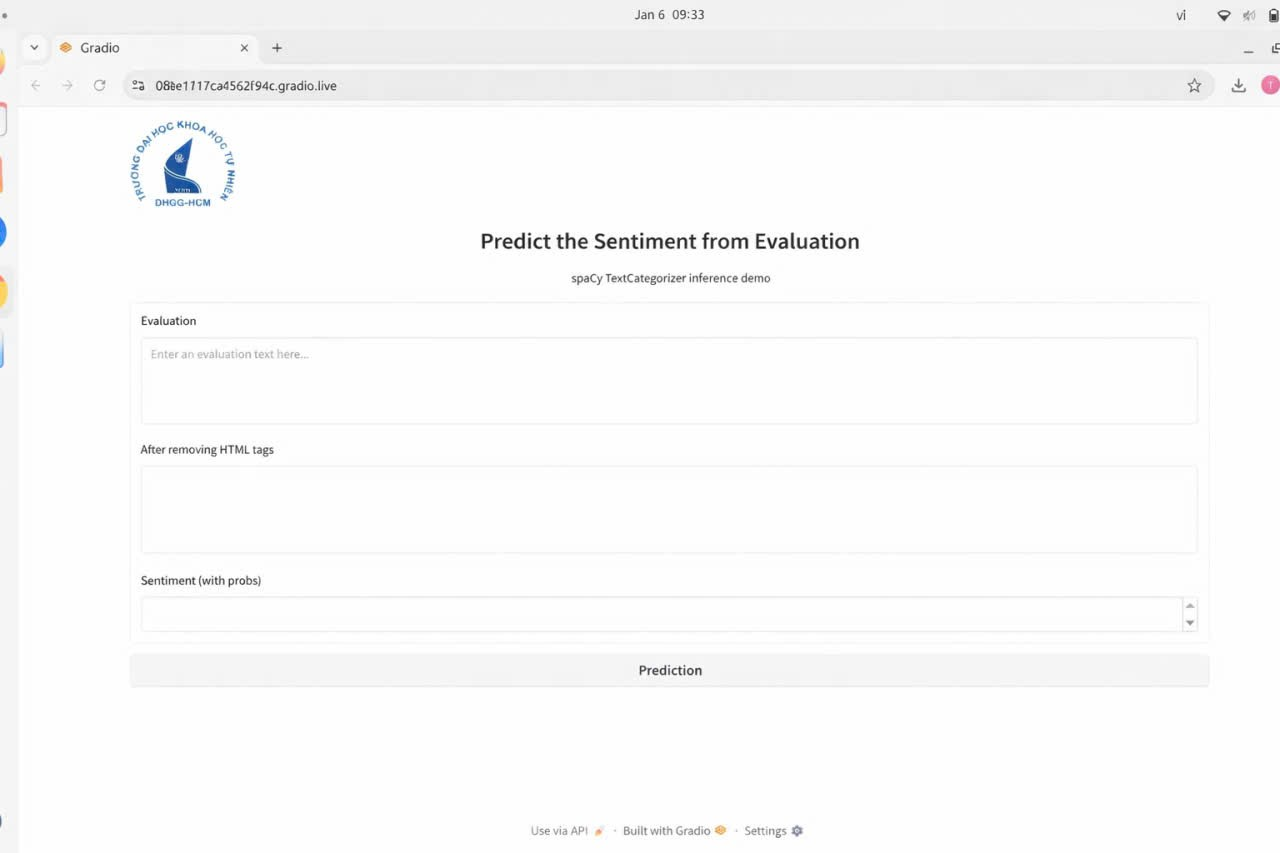

## **7. Kết luận và Hướng phát triển**



### **7.1. Kết luận**
Trong nghiên cứu này, nhóm đã xây dựng một **hệ thống phân tích cảm xúc đa lớp (Negative – Neutral – Positive)** dựa trên các phương pháp **xử lý ngôn ngữ tự nhiên (NLP) và mô hình học máy/học sâu** [1][3].

Trọng tâm của hệ thống là mô hình **spaCy TextCategorizer (CNN-based)**, được huấn luyện theo cơ chế **supervised learning** với hàm mất mát **Categorical Cross-Entropy**. Mô hình spaCy không chỉ đạt hiệu năng tốt mà còn có ưu điểm về **tốc độ suy luận nhanh**, cân bằng tốt giữa độ chính xác và chi phí tính toán, phù hợp để làm mô hình chính cho hệ thống [1][3].

### **7.2. So sánh hiệu năng**
Để đánh giá khách quan hơn về luận điểm trên, mô hình spaCy được so sánh với ba mô hình khác gồm: **Logistic Regression, Linear Regression (baseline) và BiLSTM**. Kết quả thu được như sau:

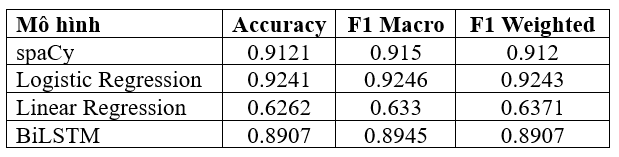

**Nhận xét chung (cho 3 mô hình có kết quả tốt)**
Cả ba mô hình đều cho kết quả chấp nhận được, với các ưu nhược điểm cụ thể [1][3]:

* **Logistic Regression:** Đạt Accuracy cao nhất nhưng **phụ thuộc mạnh** vào kỹ thuật TF-IDF. Việc phải triển khai toàn bộ pipeline tiền xử lý thủ công (Remove HTML → Lowercase → Clean Punctuation → Lemmatize → Vectorization với TF-IDF) dẫn đến tốn nhiều thời gian và chi phí tính toán.

* **spaCy TextCategorizer:** Đơn giản hơn, chỉ cần loại bỏ HTML tag đầu vào. Do preprocessing đã được tích hợp sẵn trong kiến trúc **spaCy CNN**, đây là phương án nhanh gọn, rất phù hợp cho bài toán dữ liệu lớn (~75.000 mẫu).

* **BiLSTM:** Kết quả tốt nhưng yêu cầu tài nguyên **tính toán lớn nhất**. Quy trình preprocessing tương tự Logistic Regression nhưng phức tạp hơn ở khâu input. Do cơ chế duyệt chuỗi tuần tự (thay vì song song như Logistic Regression), BiLSTM **không tối ưu** cho môi trường triển khai nhẹ.

### **7.3. Kết quả của demo Web app**

**Thử nghiệm với câu "I really like it, amazing!" thu được kết quả**
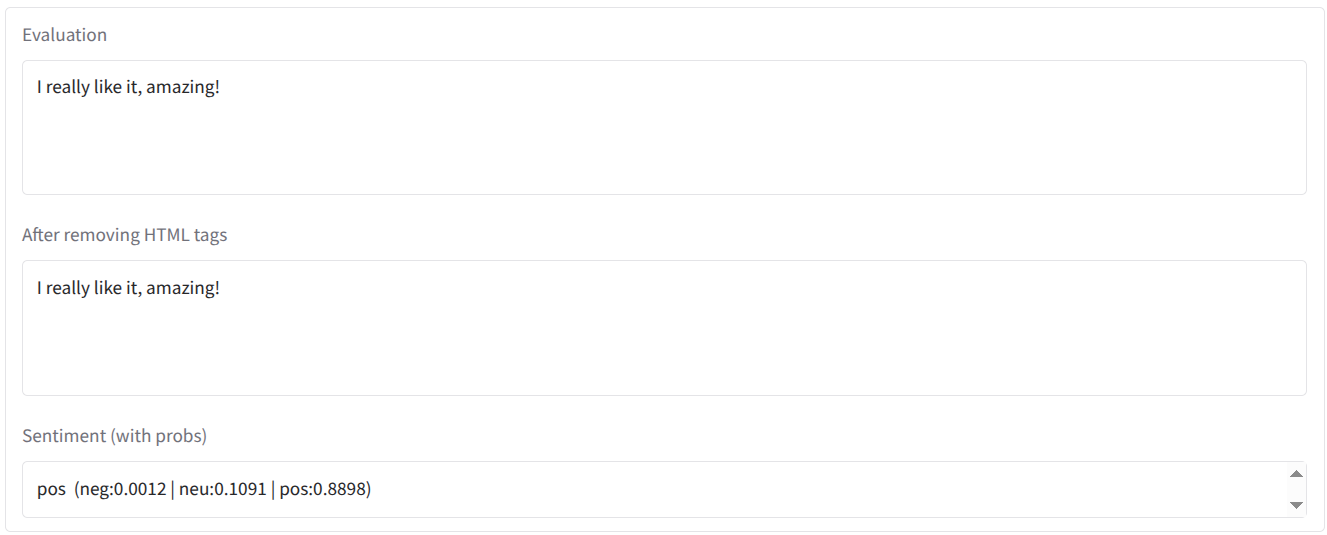

**The movie is the worst one i have seen, thu được kết quả:**
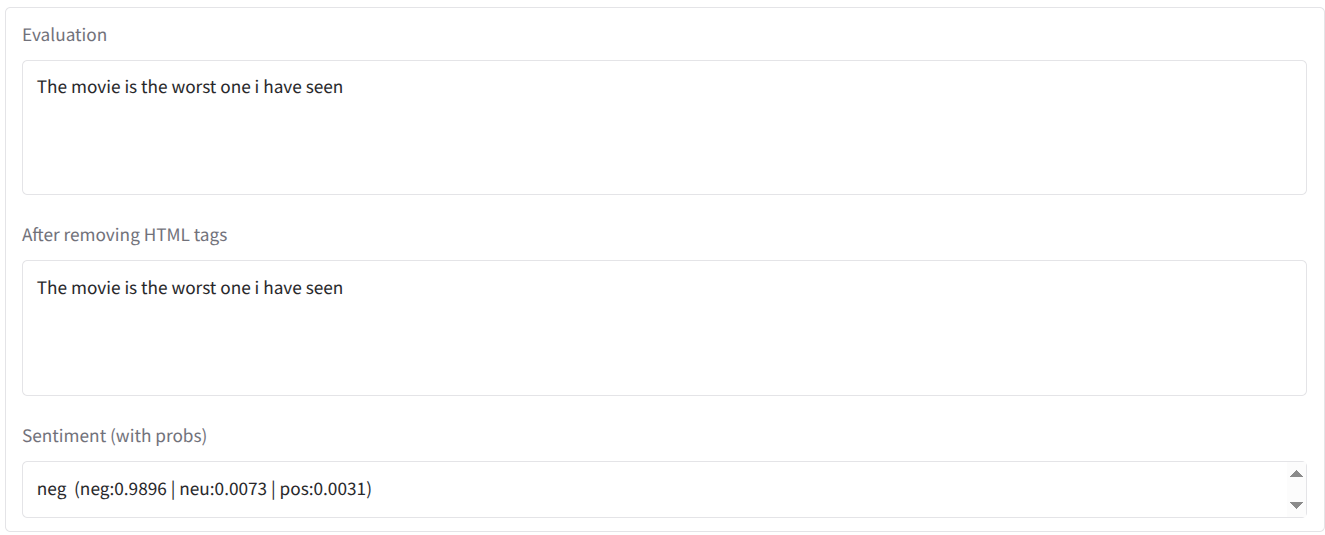


### **7.4. Hạn chế**

Mặc dù đạt được độ chính xác **91,21%**, hệ thống vẫn tồn tại hai hạn chế chính cần khắc phục:

---

#### **7.4.1. Chất lượng dữ liệu lớp Neutral**

Khoảng **25,000 mẫu Neutral** trong dataset được dịch từ tiếng Nga sang tiếng Anh [2][4]. Điều này tạo ra ba vấn đề lớn:

1. **Chất lượng của lớp Neutral ban đầu:**
   * Cách phân loại `neutral` của file gốc (tiếng Nga) chưa rõ ràng.
   * Một số sentiment có điểm trên thang 10 là dưới 5, hoặc trên 8 vẫn được xét vào `neutral` thay vì `positive` hoặc `negative`.
   * *Hệ quả:* Các mẫu này trở thành **outliers**, gây nhiễu nghiêm trọng cho quá trình huấn luyện.

2. **Vấn đề Translation Artifacts:**
   * Văn bản dịch thường giữ lại cấu trúc ngữ pháp của ngôn ngữ gốc, thiếu tự nhiên.
   * > *Ví dụ:* "This film is not bad and not good" khác xa cách diễn đạt tự nhiên "It's okay, nothing special".

3. **Hiệu năng thấp hơn:**
   * F1-score của Neutral cao hơn hẳn so với Negative và Positive.
   * *Kết luận:* Model khó học được ranh giới quyết định (decision boundary) cho lớp Neutral do dữ liệu thiếu đồng nhất [4].

---

#### **7.4.2. Hạn chế xử lý ngữ cảnh phức tạp**

Kiến trúc CNN sử dụng **convolutional filters** để trích xuất n-gram features cục bộ. Cách tiếp cận này gặp khó khăn trong hai trường hợp ngữ nghĩa [1][4]:

* **Hàm ý (Sarcasm/Irony):**
  > *"Amazing! I really loved wasting two hours of my life"*
  
  Câu chứa từ "Amazing" nhưng mang nghĩa tiêu cực. Model dễ bị nhầm lẫn bởi các từ khóa (keywords) bề mặt và bỏ qua ngữ cảnh rộng hơn [4].


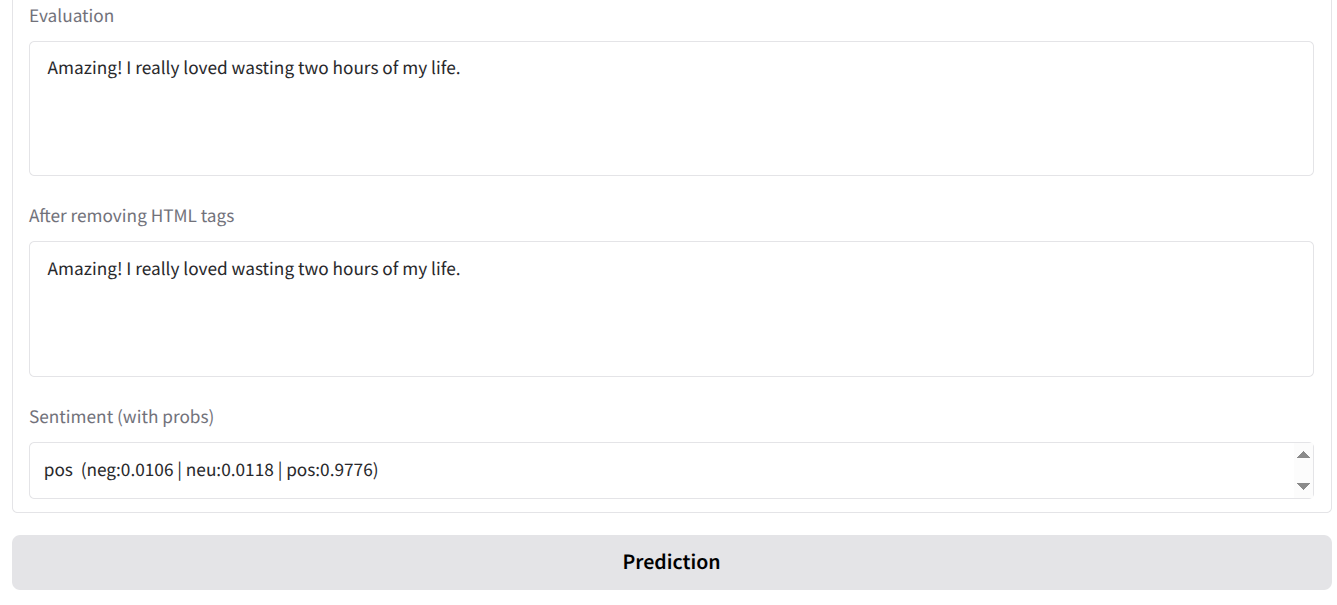

* **Phủ định kép (Double Negation):**

    > *"Not the worst movie I've ever seen"*
  
  Câu mang nghĩa trung tính/tích cực, nhưng model có thể phân loại sai thành `Negative` do sự xuất hiện của từ "worst".
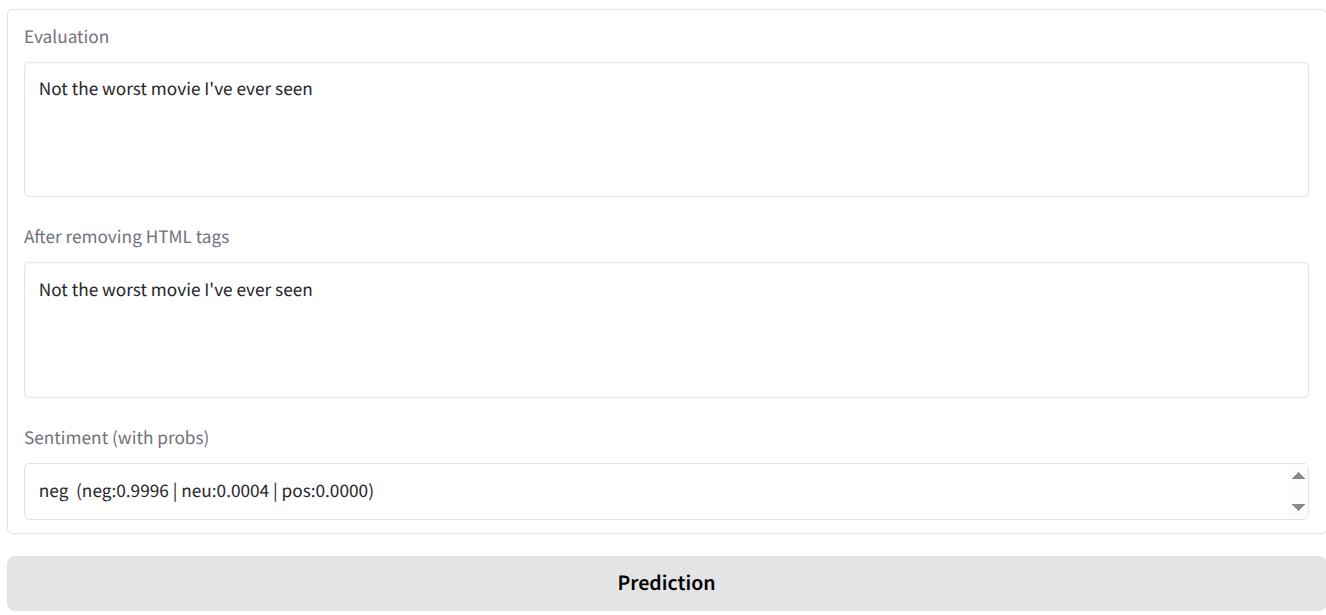


### **7.5. Hướng phát triển**

Để khắc phục các hạn chế nêu trên và nâng cao hiệu năng thực tế của hệ thống, nhóm đề xuất hai giải pháp cải tiến cụ thể [1][4]:

#### **7.5.1. Cải thiện chất lượng dữ liệu Neutral (Data Refinement)**

**Quality:** Tầm soát các outlier, xóa bỏ hoặc sửa đổi các mẫu để đảm bảo các sentiment thuộc thang điểm 6–8 được gán đúng nhãn **neutral**, tạo nên tính công bằng cho ba lớp dữ liệu [4].

**Translation: Back-Translation và Paraphrasing (Dịch ngược & Viết lại câu)**

* **Cơ chế thực hiện:**
    * **Back-Translation (Dịch vòng):** Sử dụng mô hình dịch thuật (Google Translate API) để dịch các mẫu dữ liệu từ *Tiếng Anh (gốc Nga)* sang một ngôn ngữ trung gian (ví dụ: Tiếng Đức hoặc Tiếng Pháp), sau đó dịch ngược lại *Tiếng Anh*. Quá trình này giúp làm mềm cấu trúc câu cứng nhắc và giảm các lỗi ngữ pháp đặc thù của tiếng Nga [4].

    * **Contextual Paraphrasing (Viết lại dựa trên ngữ cảnh):** Sử dụng mô hình ngôn ngữ như **T5 (Text-to-Text Transfer Transformer)** để tự động thay thế các từ hoặc cụm từ dùng sai ngữ cảnh bằng các cách diễn đạt tự nhiên hơn trong tiếng Anh [4].

* **Ví dụ minh họa:**
    * *Câu gốc (Dịch từ Nga):* "Film is not bad and not good, logic is missing."
    * *Sau khi xử lý:* "The movie is neither bad nor good, but it lacks logic."

=> Giữ lại **25,000 mẫu Neutral** có giá trị nhưng nâng cao chất lượng ngôn ngữ, giúp mô hình spaCy học được các đặc trưng ngữ nghĩa chuẩn xác hơn và cải thiện độ chính xác phân loại lớp Neutral [4].

#### **7.5.2. Tích hợp mô hình Transformer để xử lý ngữ cảnh**

Kiến trúc CNN hiện tại bị giới hạn trong việc trích xuất đặc trưng cục bộ, dẫn đến sai sót khi gặp các câu châm biếm (sarcasm) hoặc phủ định kép. Để khắc phục, cần chuyển sang kiến trúc dựa trên **Attention Mechanism** [1][4].

* **Phương pháp:**
    * Áp dụng **Transfer Learning** với các mô hình ngôn ngữ lớn như **BERT** hoặc phiên bản gọn nhẹ hơn là **DistilBERT** [4].
    * Khai thác cơ chế **Self-Attention** của Transformer, cho phép mô hình nắm bắt mối quan hệ dài hạn giữa các từ trong câu, từ đó hiểu đúng các cấu trúc mỉa mai và ngữ cảnh phức tạp [4].

=> Giải pháp này kỳ vọng cải thiện đáng kể độ chính xác trên các câu đa nghĩa, nâng cao Accuracy tổng thể lên mức **93–94%** [4].

## **8. Tài liệu tham khảo**


[1] Real Python. *Sentiment Analysis in Python*.  
https://realpython.com/sentiment-analysis-python/

[2] Sameer Ansarii. *Sentiment Analysis on IMDB Movie Reviews (GitHub Repository)*.  
https://github.com/Sameer-ansarii/Sentiment-Analysis-on-IMDB-Movie-Reviews

[3] GeeksforGeeks. *Sentiment Analysis on IMDB Movie Reviews*.  
https://www.geeksforgeeks.org/nlp/sentiment-analysis-on-imdb-movie-reviews/

[4] Dhaniya Pudina. *Sentiment Analysis on IMDB Movie Reviews using BERT (Kaggle Notebook)*.  
https://www.kaggle.com/code/dhaniyapudina/sentiment-analysis-on-imdb-movie-review-using-bert